This script determines cell type specific genes based on McCarroll lab's adult mouse brain drop-seq data. 

In [23]:
import numpy as np
import pandas as pd

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
from matplotlib_venn import venn3

In [26]:
import heapq
import scipy.stats as stats

In [27]:
import statsmodels.api as sm
import matplotlib.ticker as mtick

In [28]:
from statannot import add_stat_annotation

In [29]:
import pingouin as pg

In [30]:
matplotlib.rcParams['figure.dpi']= 300

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [32]:
annotation_df = pd.read_excel('../data/single-cell/saunders_2018/annotation.BrainCellAtlas_Saunders_version_2018.04.01.xlsx')

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [190]:
annotation_df[annotation_df['class']=='NEURON'].to_csv('../results/single-cell/saunders_2018/annotation-neuronal_classes.tsv',sep='\t')
# Then manually assign excitatory versus inhibitory to neuronal cell classes

In [33]:
class_dict = {
    'NEURON':'Neuron', 
    'ENDOTHELIAL_STALK':'Vasculature', 
    'ENDOTHELIAL_TIP':'Vasculature', 
    'MURAL':'Vasculature',
    'MICROGLIA':'Glia',
    'OLIGODENDROCYTE':'Glia',
    'POLYDENDROCYTE':'Glia', 
    'ASTROCYTE':'Glia',
    'CHOROID_PLEXUS':'Vasculature', 
    'MACROPHAGE':'Glia', 
    'MITOTIC':'Mitotic', 
    'EPENDYMAL':'Vasculature',
    'NEUROGENESIS':'Neuron'
}

In [34]:
annotation_df['master_class']=annotation_df['class'].map(class_dict)

In [35]:
cluster_dict={}
Neuron_cluster_list=[]
Vasculature_cluster_list=[]
Glia_cluster_list=[]
Mitotic_cluster_list=[]
for index, row in annotation_df.iterrows():
    cluster_dict[row['tissue_subcluster']]=row['master_class']
    if row['master_class']=='Neuron':
        Neuron_cluster_list.append(row['tissue_subcluster'])
    elif row['master_class']=='Vasculature':
        Vasculature_cluster_list.append(row['tissue_subcluster'])
    elif row['master_class']=='Glia':
        Glia_cluster_list.append(row['tissue_subcluster'])
    elif row['master_class']=='Mitotic':
        Mitotic_cluster_list.append(row['tissue_subcluster'])

In [36]:
# expression level in aggregated UMIs of each gene in each metacell
metacell_df = pd.read_csv('../data/single-cell/saunders_2018/metacells.BrainCellAtlas_Saunders_version_2018.04.01.csv', index_col=[0])

In [37]:
metacell_df.shape

(32307, 565)

In [53]:
metacell_df['CB_10-1']

0610005C13Rik    0
0610007P14Rik    7
0610009B22Rik    2
0610009E02Rik    5
0610009L18Rik    1
                ..
n-R5s172         0
n-R5s50          0
n-R5s61          0
n-R5s92          0
n-R5s94          0
Name: CB_10-1, Length: 32307, dtype: int64

In [44]:
metacell_mean_series = metacell_df.mean(axis=0)

In [45]:
metacell_sum_series = metacell_df.sum(axis=0)

In [52]:
metacell_sum_series['CB_10-1']

136551

In [38]:
metacell_UMI_list = metacell_df.values.flatten().tolist()

In [54]:
# Create a dataframe of expression by normalizing the aggregated UMI to total expression 
norm_exp_df = metacell_df/metacell_sum_series

In [55]:
num_cell_df=pd.read_csv('../data/single-cell/saunders_2018/subcluster_stats.csv')

In [56]:
num_cell_df

,Unnamed: 0,tissue,cluster,cluster_name,subcluster,full_name,num_cells
0,1,P60Cerebellum_ALT,1,GranularNeuron_Gabra6,1-1,Neuron.Slc17a7.Gabra6,10243.0
1,2,P60Cerebellum_ALT,2,PurkinjeNeuron_Pcp2,2-1,Neuron.Gad1Gad2.Pcp2,89.0
2,3,P60Cerebellum_ALT,3,Interneurons_Pvalb,3-1,Neuron.Gad1Gad2.Pvalb-Nefh,360.0
3,4,P60Cerebellum_ALT,3,Interneurons_Pvalb,3-2,Neuron.Gad1Gad2.Pvalb-Rab3b,196.0
4,5,P60Cerebellum_ALT,3,Interneurons_Pvalb,3-3,Neuron.Gad1Gad2.Pvalb-Cadm1,101.0
...,...,...,...,...,...,...,...
602,603,P60Thalamus,12,Polydendrocyte_Tnr,12-3,Polydendrocyte.Tnr.Bmp4,159.0
603,604,P60Thalamus,12,Polydendrocyte_Tnr,12-4,Polydendrocyte.Tnr.Cspg5,53.0
604,605,P60Thalamus,13,Polydendrocytes_Cacng4,NaN,NaN,NaN
605,606,P60Thalamus,14,Bcell_Cd74,NaN,NaN,NaN


In [60]:
metacell_df.columns.unique().tolist()

['CB_1-1',
 'CB_10-1',
 'CB_10-2',
 'CB_10-3',
 'CB_11-1',
 'CB_11-2',
 'CB_11-3',
 'CB_11-4',
 'CB_11-5',
 'CB_2-1',
 'CB_3-1',
 'CB_3-2',
 'CB_3-3',
 'CB_3-4',
 'CB_4-1',
 'CB_4-2',
 'CB_4-3',
 'CB_5-1',
 'CB_6-1',
 'CB_6-2',
 'CB_6-3',
 'CB_7-1',
 'CB_8-1',
 'CB_8-2',
 'CB_9-1',
 'FC_1-1',
 'FC_1-10',
 'FC_1-11',
 'FC_1-2',
 'FC_1-3',
 'FC_1-4',
 'FC_1-5',
 'FC_1-6',
 'FC_1-7',
 'FC_1-8',
 'FC_1-9',
 'FC_10-1',
 'FC_10-2',
 'FC_10-3',
 'FC_10-4',
 'FC_10-5',
 'FC_10-6',
 'FC_11-1',
 'FC_11-2',
 'FC_11-3',
 'FC_11-4',
 'FC_12-1',
 'FC_12-2',
 'FC_12-3',
 'FC_12-4',
 'FC_12-5',
 'FC_13-1',
 'FC_13-2',
 'FC_13-3',
 'FC_13-4',
 'FC_14-1',
 'FC_14-2',
 'FC_14-3',
 'FC_14-4',
 'FC_14-5',
 'FC_2-1',
 'FC_2-10',
 'FC_2-2',
 'FC_2-3',
 'FC_2-4',
 'FC_2-5',
 'FC_2-6',
 'FC_2-7',
 'FC_2-8',
 'FC_2-9',
 'FC_3-1',
 'FC_3-10',
 'FC_3-11',
 'FC_3-12',
 'FC_3-13',
 'FC_3-2',
 'FC_3-3',
 'FC_3-4',
 'FC_3-5',
 'FC_3-6',
 'FC_3-7',
 'FC_3-8',
 'FC_3-9',
 'FC_4-1',
 'FC_4-2',
 'FC_5-1',
 'FC_6-1',
 'FC

In [211]:
metacell_df['mean']=metacell_to_listan(axis=1)

In [212]:
metacell_df['Neuron_mean']=metacell_df[Neuron_cluster_list].mean(axis=1)
metacell_df['Vasculature_mean']=metacell_df[Vasculature_cluster_list].mean(axis=1)
metacell_df['Glia_mean']=metacell_df[Glia_cluster_list].mean(axis=1)
metacell_df['Mitotic_mean']=metacell_df[Mitotic_cluster_list].mean(axis=1)

In [213]:
metacell_df['Neuron_std']=metacell_df[Neuron_cluster_list].std(axis=1)
metacell_df['Glia_std']=metacell_df[Glia_cluster_list].std(axis=1)
metacell_df['Vasculature_std']=metacell_df[Vasculature_cluster_list].std(axis=1)

In [214]:
metacell_df['Neuron_min']=metacell_df[Neuron_cluster_list].min(axis=1)
metacell_df['Glia_min']=metacell_df[Glia_cluster_list].min(axis=1)
metacell_df['Vasculature_min']=metacell_df[Vasculature_cluster_list].min(axis=1)

In [215]:
metacell_df[metacell_df['mean']>0].shape
# There are 32307-31309=998 genes with no detectable expression

(31309, 576)

In [216]:
non_zero_UMI_list=[i for i in metacell_UMI_list if i != 0]

In [217]:
min(non_zero_UMI_list)

1

In [218]:
len(non_zero_UMI_list)

7277937

[None]

<AxesSubplot:ylabel='Count'>

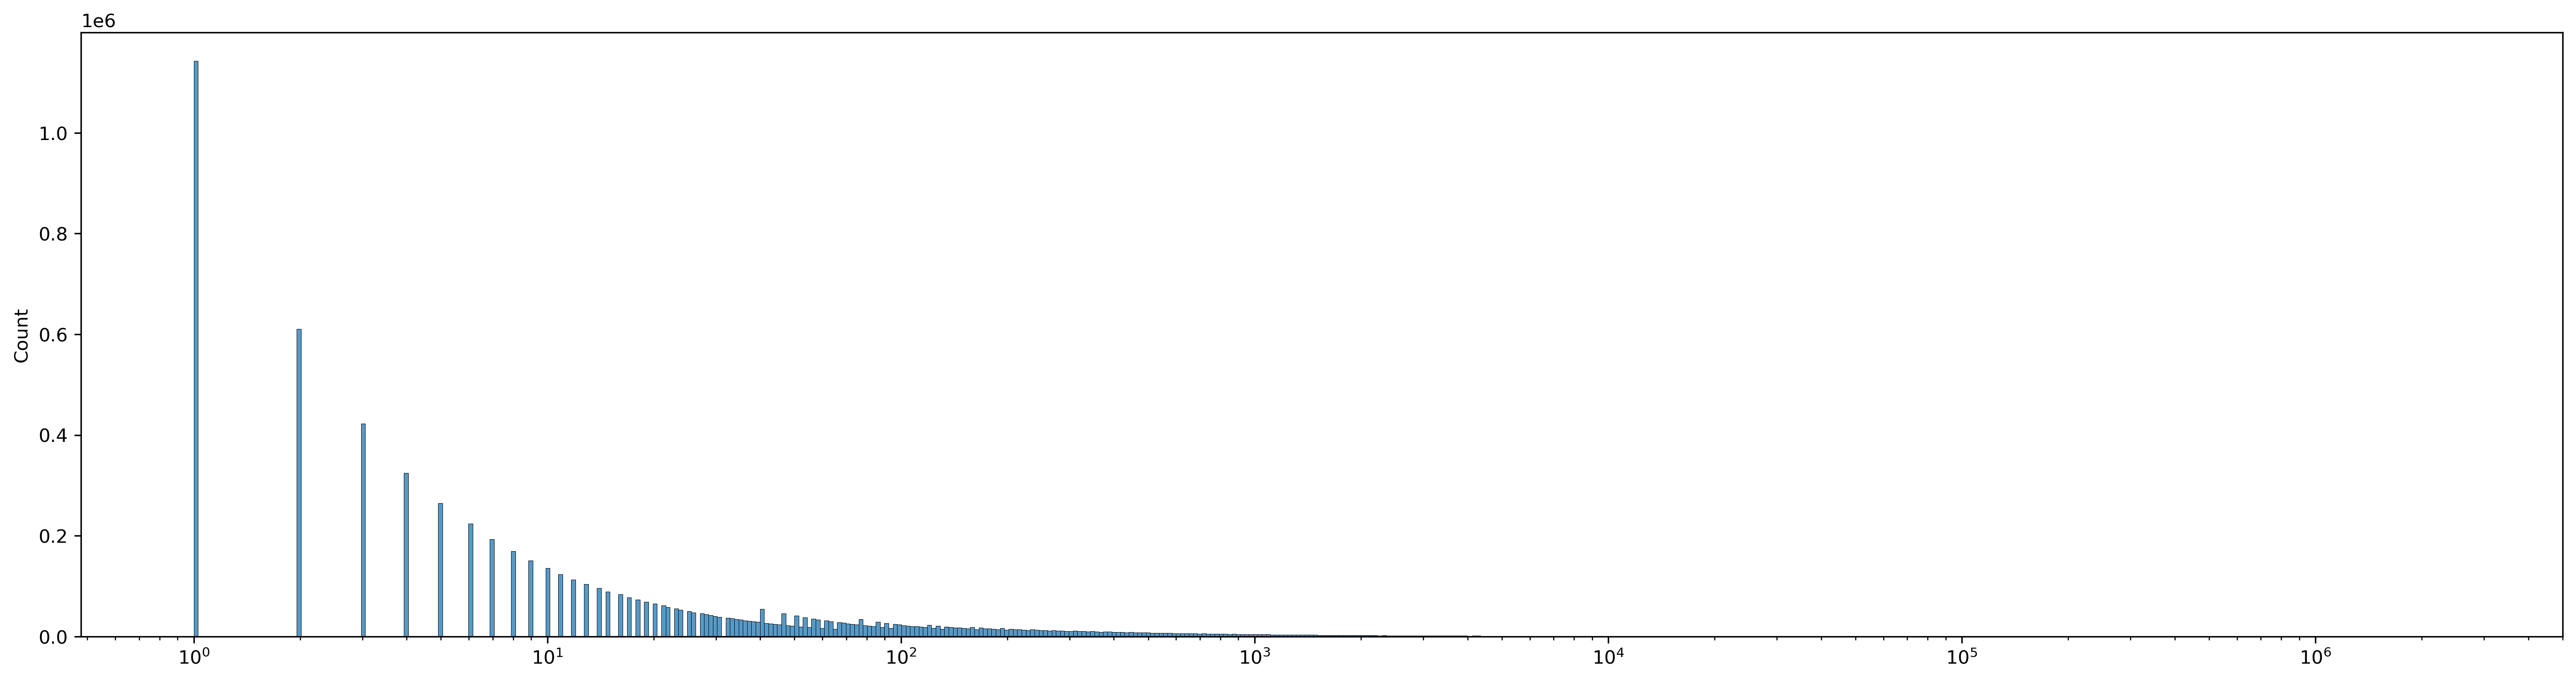

In [219]:
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(non_zero_UMI_list,ax=ax)
# plt.xlim([0, 100000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/2546146506.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0007536017362068288, 50000)

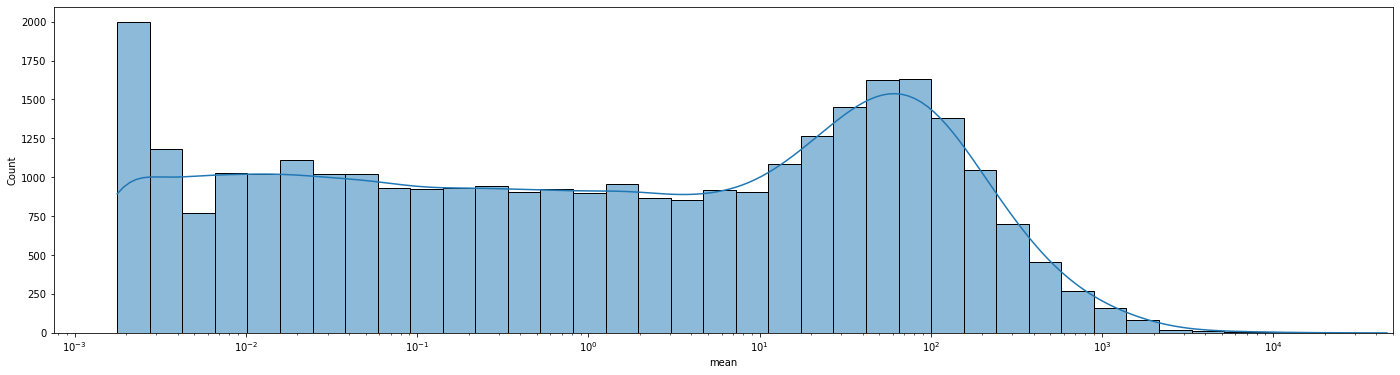

In [28]:
df=metacell_df[metacell_df['mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='mean', kde=True)
plt.xlim([0, 50000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/3566739292.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0012874968030502302, 50000)

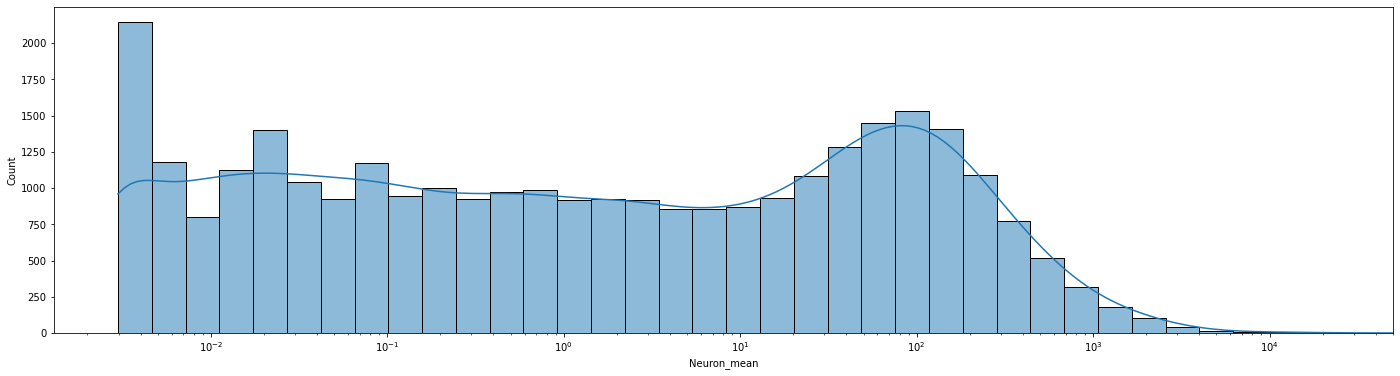

In [35]:
df=metacell_df[metacell_df['Neuron_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Neuron_mean', kde=True)
plt.xlim([0, 50000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/3855273330.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.004656683052336018, 50000)

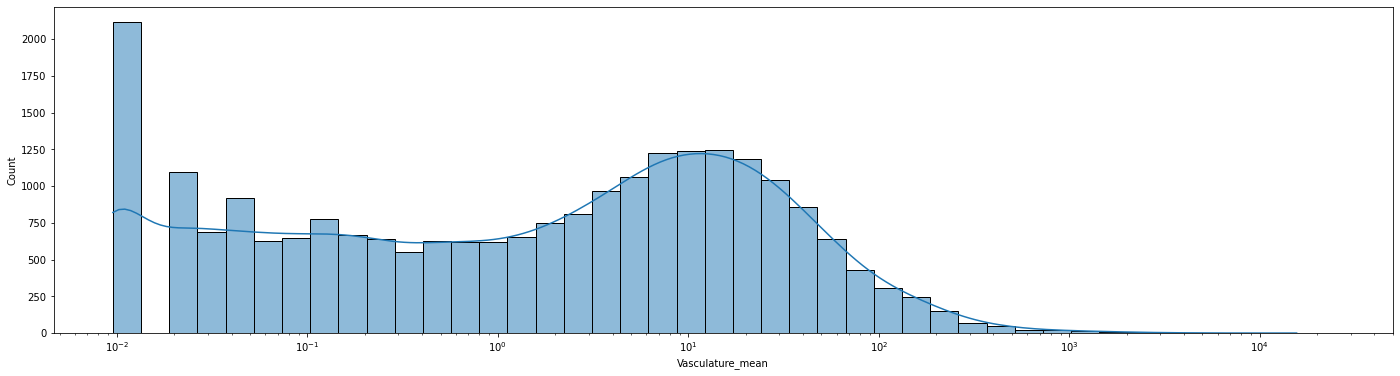

In [36]:
df=metacell_df[metacell_df['Vasculature_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Vasculature_mean', kde=True)
plt.xlim([0, 50000])

/var/folders/_g/l621c6655y96l4zm2nwpfyq00000gn/T/ipykernel_14614/1820051918.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 50000])


(0.0035720831634785686, 50000)

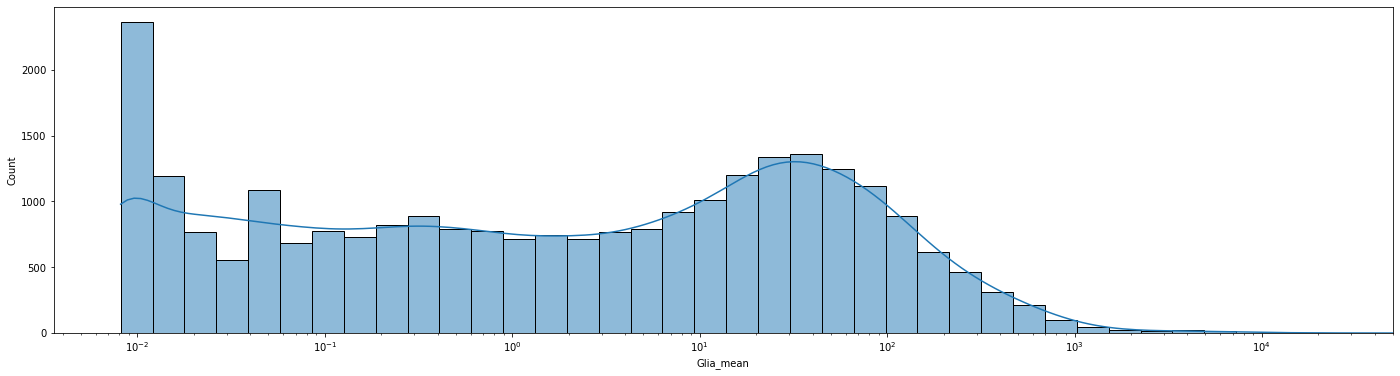

In [37]:
df=metacell_df[metacell_df['Glia_mean']>0]
fig, ax = plt.subplots(figsize=(24,6))
ax.set(xscale="log")
sns.histplot(ax=ax,data=df,x='Glia_mean', kde=True)
plt.xlim([0, 50000])

In [117]:
# Define neuron-, glia-, and vasculature-expressed genes as genes with more than 10M average UMIs
metacell_df['Neuron-expressed']=0
metacell_df['Glia-expressed']=0
metacell_df['Vasculature-expressed']=0
metacell_df.loc[metacell_df.Neuron_mean>=100,'Neuron-expressed']=1
metacell_df.loc[metacell_df.Glia_mean>=100,'Glia-expressed']=1
metacell_df.loc[metacell_df.Vasculature_mean>=100,'Vasculature-expressed']=1

In [118]:
metacell_df[metacell_df['Neuron-expressed']==1].shape
metacell_df[metacell_df['Glia-expressed']==1].shape
metacell_df[metacell_df['Vasculature-expressed']==1].shape

(5056, 585)

(2657, 585)

(836, 585)

In [119]:
# Genes with expression greater or equal to 100k in all cluster of that master class
# AND with expression greater than 10M when averaged across all cluster of that master class
metacell_df['Neuron-expressed-universal']=0
metacell_df['Glia-expressed-universal']=0
metacell_df['Vasculature-expressed-universal']=0

metacell_df.loc[(metacell_df['Vasculature_min']>0)&(metacell_df['Vasculature_mean']>=100),'Vasculature-expressed-universal']=1
metacell_df.loc[(metacell_df['Neuron_min']>0)&(metacell_df['Neuron_mean']>=100),'Neuron-expressed-universal']=1
metacell_df.loc[(metacell_df['Glia_min']>0)&(metacell_df['Glia_mean']>=100),'Glia-expressed-universal']=1

In [120]:
metacell_df[metacell_df['Neuron-expressed-universal']==1].shape
metacell_df[metacell_df['Glia-expressed-universal']==1].shape
metacell_df[metacell_df['Vasculature-expressed-universal']==1].shape

(890, 585)

(357, 585)

(485, 585)

In [137]:
N_set = set(metacell_df[metacell_df['Neuron-expressed']==1].index)
G_set = set(metacell_df[metacell_df['Glia-expressed']==1].index)
V_set = set(metacell_df[metacell_df['Vasculature-expressed']==1].index)

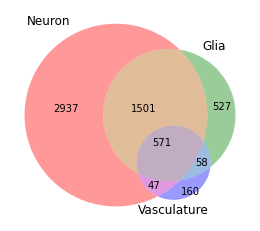

In [138]:
venn3([N_set,G_set,V_set],set_labels=('Neuron','Glia','Vasculature'))

In [135]:
NU_set = set(metacell_df[metacell_df['Neuron-expressed-universal']==1].index)
GU_set = set(metacell_df[metacell_df['Glia-expressed-universal']==1].index)
VU_set = set(metacell_df[metacell_df['Vasculature-expressed-universal']==1].index)

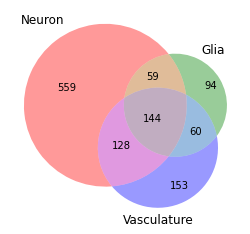

In [136]:
venn3([NU_set,GU_set,VU_set],set_labels=('Neuron','Glia','Vasculature'))

In [146]:
a={1,2,4,5,6}
b={5,6,4,9}
c={1}
a&(a^b)&(a^c)

{2}

In [152]:
# Define neuron-, glia-, and vasculature-specific genes
metacell_df['Neuron-specific']=0
metacell_df['Glia-specific']=0
metacell_df['Vasculature-specific']=0
NS_set=NU_set&(NU_set^GU_set)&(NU_set^VU_set)
GS_set=GU_set&(GU_set^NU_set)&(GU_set^VU_set)
VS_set=VU_set&(VU_set^NU_set)&(VU_set^GU_set)
metacell_df.loc[list(NS_set),'Neuron-specific']=1
metacell_df.loc[list(GS_set),'Glia-specific']=1
metacell_df.loc[list(VS_set),'Vasculature-specific']=1

In [153]:
metacell_df[metacell_df["Neuron-specific"]==1].shape
metacell_df[metacell_df["Glia-specific"]==1].shape
metacell_df[metacell_df["Vasculature-specific"]==1].shape

(559, 585)

(94, 585)

(153, 585)

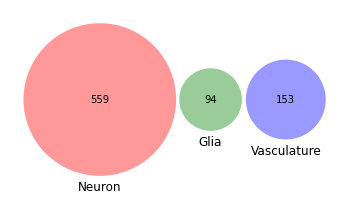

In [154]:
venn3([NS_set,GS_set,VS_set],set_labels=('Neuron','Glia','Vasculature'))

In [159]:
avg_dNdS_df=pd.read_csv('../results/Ensembl98_mouse/mouse.dNdS_stats.all_genes.tsv',sep='\t',usecols=['Gene name','mean'],index_col='Gene name')

In [163]:
avg_dNdS_df.rename(columns={'mean':'avg_dNdS'},inplace=True)

In [166]:
merge_df=pd.merge(left=metacell_df,right=avg_dNdS_df,left_index=True,right_index=True,how="inner")

In [167]:
merge_df[merge_df["Neuron-specific"]==1].shape
merge_df[merge_df["Glia-specific"]==1].shape
merge_df[merge_df["Vasculature-specific"]==1].shape

(540, 586)

(91, 586)

(133, 586)

In [171]:
N_arr=merge_df[merge_df["Neuron-specific"]==1]['avg_dNdS'].dropna().values
G_arr=merge_df[merge_df["Glia-specific"]==1]['avg_dNdS'].dropna().values
V_arr=merge_df[merge_df["Vasculature-specific"]==1]['avg_dNdS'].dropna().values

Text(0.5, 0.98, 'Distribution of dN/dS of Mouse Cell Type-specific Genes Based on Saunders et al 2018')

Text(0.5, 0, 'dN/dS')

Text(0, 0.5, 'number of genes')

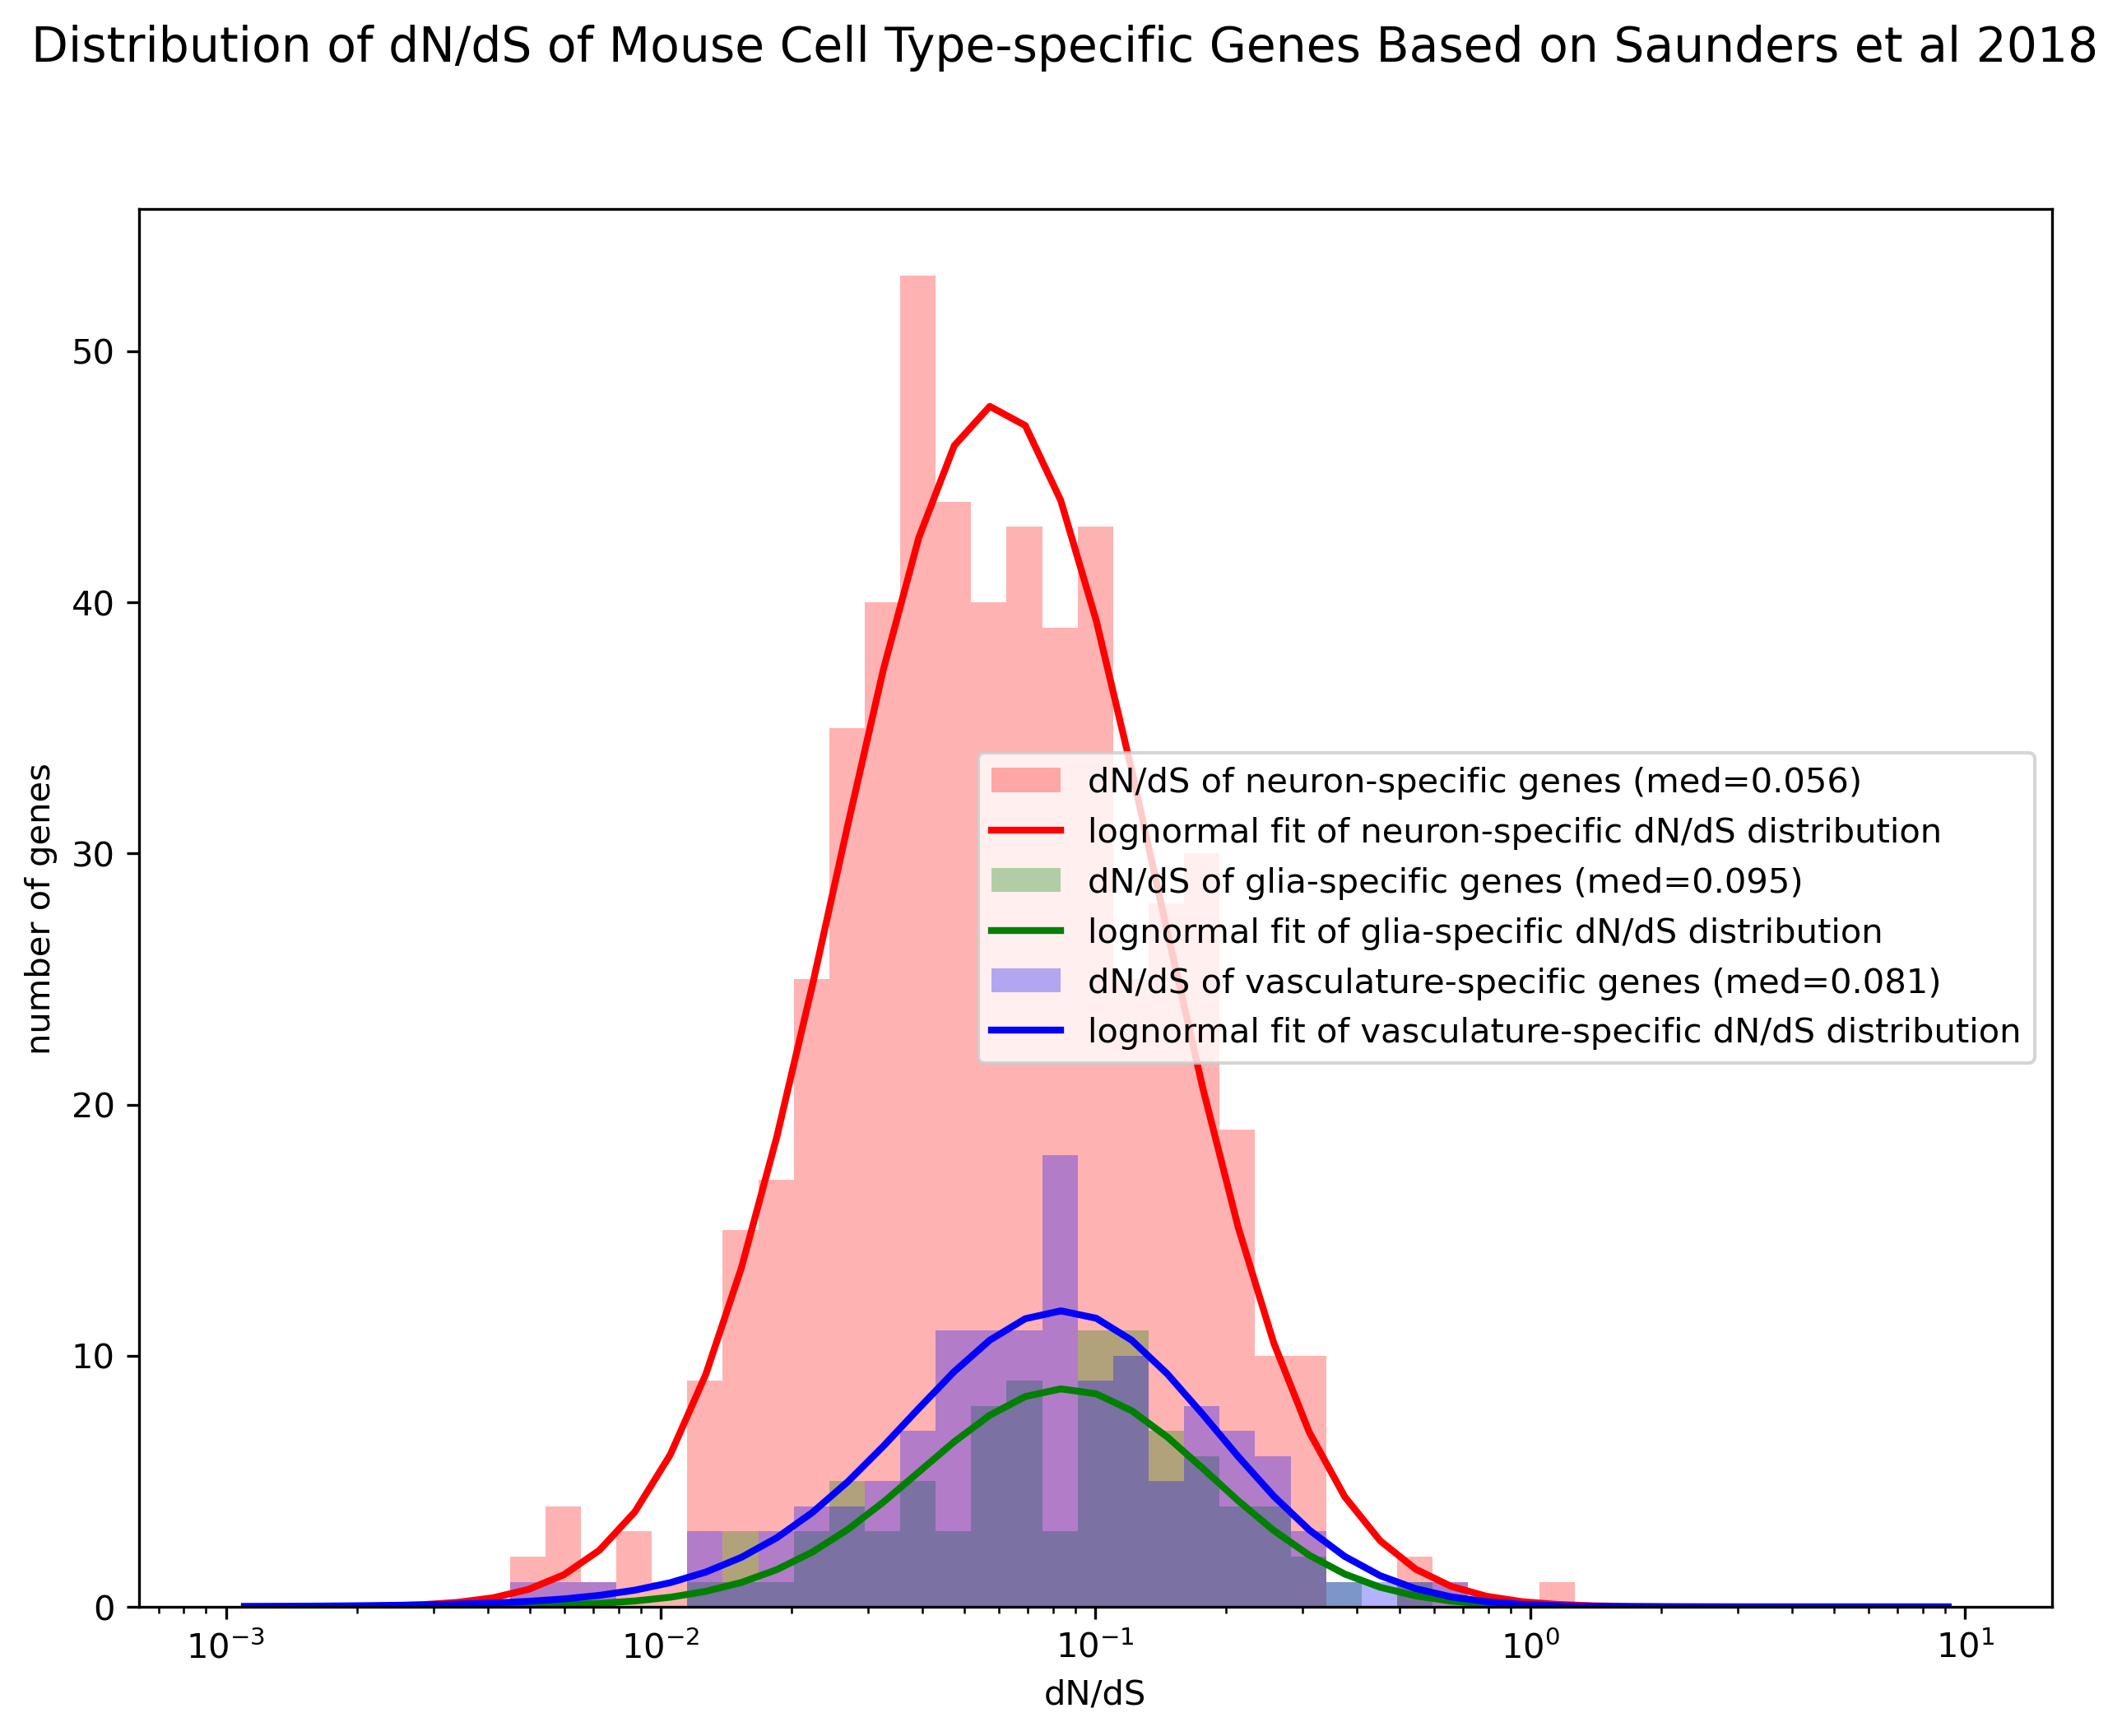

In [182]:
# Creating a figure 
fig = plt.figure(figsize=(10,7.5)) # Size of a letter size paper in horizontal
fig.suptitle('Distribution of dN/dS of Mouse Cell Type-specific Genes Based on Saunders et al 2018', fontsize=14)

# Setting subplot space
grid = plt.GridSpec(nrows=1,ncols=1)
#grid.update(wspace=0.5, hspace=0.3)

# The subplot for distribution histogram 
distr_plot = fig.add_subplot(grid[:,:])
#distr_hist = dist_GO_df.plot(ax=distr_plot, kind='hist',alpha=0.3,bins=np.logspace(np.log10(0.001),np.log10(10), 100), logx=True, color=['royalblue','orange','lightgreen'])

# Set up the bins for log scale x-axis, and get the centers
bins=np.logspace(np.log10(0.001),np.log10(10), 50)
bins_cntr = (bins[1:] + bins[:-1]) / 2

# Neuron-specific genes' dN/dS histogram and curve
N_counts, N_bin_edges, ignored = distr_plot.hist(N_arr,bins,histtype='stepfilled',alpha=0.3,color='red',label='dN/dS of neuron-specific genes (med={0:.3f})'.format(np.median(N_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    N_area_hist = ((N_bin_edges[1:] - N_bin_edges[:-1]) * N_counts).sum()
    N_shape, N_loc, N_scale = stats.lognorm.fit(N_arr)
    # pdf-values using cdf 
    N_fit_log_cntr_ = stats.lognorm.cdf(bins, N_shape, loc=N_loc, scale=N_scale)
    N_fit_log_cntr = np.diff(N_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, N_fit_log_cntr * N_counts.sum(),'r-', 
                    label='lognormal fit of neuron-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass

# Glia-specific genes' dN/dS histogram and curve
G_counts, G_bin_edges, ignored = distr_plot.hist(G_arr,bins,histtype='stepfilled',alpha=0.3,color='green',label='dN/dS of glia-specific genes (med={0:.3f})'.format(np.median(G_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    G_area_hist = ((G_bin_edges[1:] - G_bin_edges[:-1]) * G_counts).sum()
    G_shape, G_loc, G_scale = stats.lognorm.fit(G_arr)
    # pdf-values using cdf 
    G_fit_log_cntr_ = stats.lognorm.cdf(bins, G_shape, loc=G_loc, scale=G_scale)
    G_fit_log_cntr = np.diff(G_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, G_fit_log_cntr * G_counts.sum(),'g-', 
                    label='lognormal fit of glia-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass


# Vasculature-specific genes' dN/dS histogram and curve
V_counts, V_bin_edges, ignored = distr_plot.hist(V_arr,bins,histtype='stepfilled',alpha=0.3,color='blue',label='dN/dS of vasculature-specific genes (med={0:.3f})'.format(np.median(V_arr)))
try:
    # calculate area of histograms (area under PDF should be 1)
    V_area_hist = ((V_bin_edges[1:] - V_bin_edges[:-1]) * V_counts).sum()
    V_shape, V_loc, V_scale = stats.lognorm.fit(V_arr)
    # pdf-values using cdf 
    V_fit_log_cntr_ = stats.lognorm.cdf(bins, V_shape, loc=V_loc, scale=V_scale)
    V_fit_log_cntr = np.diff(V_fit_log_cntr_)
    # plot fitted and scaled PDFs into histogram
    distr_plot.plot(bins_cntr, V_fit_log_cntr * V_counts.sum(),'b-', 
                    label='lognormal fit of vasculature-specific dN/dS distribution', linewidth=2)
except ValueError:
    pass

# Axis labels
distr_plot.set_xlabel(xlabel='dN/dS')
distr_plot.set_ylabel(ylabel='number of genes')
distr_plot.set_xscale('log')
distr_plot.legend(loc='best')
# distr_plot.yaxis.set_major_formatter(mtick.PercentFormatter(1))

# fig.savefig('../figures/mouse.organs.pdf')
# fig.savefig('../figures/mouse.organs.eps')
# fig.savefig('../figures/mouse.organs.png')
# plt.close()

In [185]:
pg.mwu(N_arr,G_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,18992.0,two-sided,0.000526,0.227025,0.386488


In [186]:
pg.mwu(N_arr,V_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,29372.0,two-sided,0.001134,0.182066,0.408967


In [187]:
pg.mwu(G_arr,V_arr,alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,6366.0,two-sided,0.509801,-0.051971,0.525985
